In [1]:
from pathlib import Path
import sys

# --- Notebook bootstrap (works from repo root or notebooks/) ---
REPO_ROOT = Path.cwd()
if not (REPO_ROOT / 'mm').exists():
    REPO_ROOT = REPO_ROOT.parent
sys.path.insert(0, str(REPO_ROOT))

DATA_ROOT = REPO_ROOT / 'data'
OUT_ROOT = REPO_ROOT / 'out'

print('REPO_ROOT:', REPO_ROOT)


REPO_ROOT: /Users/hoangdeveloper/PycharmProjects/MMPrototype


# Calibration schedule QA\n\nThis notebook loads the outputs of **Mode B** (schedule-only calibration) and provides a small set of QA plots and diagnostics.\n\nExpected inputs (produced by `python -m mm.runner_calibrate_schedule`):\n- `poisson_schedule.json`\n- `window_metrics.csv`\n\nOptionally, it can also load the day’s market data (trades) to correlate parameters with regime metrics (trade rate / realized volatility proxies).\n

In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- EDIT THESE ---
RUN_DIR = OUT_ROOT / 'calibration/schedules/BTCUSDT/20251222_20260111T230155Z'  # folder containing manifest.json
# DATA_ROOT is provided by the bootstrap cell
SYMBOL = 'BTCUSDT'
DAY = '20251222'


In [20]:
def resolve_path(p: Path, root: Path) -> Path:
    return p if p.is_absolute() else (root / p).resolve()

def find_project_root(start: Path | None = None) -> Path:
    """
    Heuristic: walk upwards until we find repo markers.
    Adjust markers to match your repo layout.
    """
    p = (start or Path.cwd()).resolve()
    for cand in [p, *p.parents]:
        if (cand / "mm").is_dir() and (cand / "out").exists():
            return cand
        # Alternative marker: pyproject.toml / setup.cfg / .git
        if (cand / "pyproject.toml").exists() or (cand / ".git").exists():
            return cand
    # Fallback: assume current working directory is root
    return p

PROJECT_ROOT = find_project_root()


In [22]:
manifest_path = RUN_DIR / "manifest.json"
if manifest_path.exists():
    manifest = json.loads(manifest_path.read_text(encoding="utf-8"))

    schedule_path = resolve_path(Path(manifest["schedule_path"]), PROJECT_ROOT)
    metrics_path  = resolve_path(Path(manifest["window_metrics_csv"]), PROJECT_ROOT)

else:
    schedule_path = RUN_DIR / "poisson_schedule.json"
    metrics_path  = RUN_DIR / "window_metrics.csv"

df = pd.read_csv(metrics_path)

df['start_dt'] = pd.to_datetime(df['start_ms'], unit='ms', utc=True)
df['end_dt'] = pd.to_datetime(df['end_ms'], unit='ms', utc=True)
df['lambda_d1'] = df['A'] * np.exp(-df['k'] * 1)
df['lambda_d3'] = df['A'] * np.exp(-df['k'] * 3)
df['lambda_d8'] = df['A'] * np.exp(-df['k'] * 8)

display(df.head())
print('Segments:', len(df), 'usable_ratio:', float(df['usable'].mean()) if len(df) else None)



,start_ms,end_ms,A,k,usable,reason,train_start_ms,train_end_ms,calib_dir,dt_ms,tick_size,exposure_s_total,fills_total,n_deltas_usable,start_dt,end_dt,lambda_d1,lambda_d3,lambda_d8
0,1766394000168,1766394900168,1.140218,0.027386,True,OK,1766386800168,1766394000168,out/calibration/schedules/BTCUSDT/20251222_202...,100,0.01,12074.034,0,6,2025-12-22 09:00:00.168000+00:00,2025-12-22 09:15:00.168000+00:00,1.109415,1.050284,0.915880
1,1766394900168,1766395800168,1.133669,0.020111,True,OK,1766387700168,1766394900168,out/calibration/schedules/BTCUSDT/20251222_202...,100,0.01,12229.851,0,6,2025-12-22 09:15:00.168000+00:00,2025-12-22 09:30:00.168000+00:00,1.111097,1.067293,0.965189
2,1766395800168,1766396700168,1.138685,0.018452,True,OK,1766388600168,1766395800168,out/calibration/schedules/BTCUSDT/20251222_202...,100,0.01,11936.499,0,6,2025-12-22 09:30:00.168000+00:00,2025-12-22 09:45:00.168000+00:00,1.117868,1.077367,0.982419
3,1766396700168,1766397600168,1.219786,0.028892,True,OK,1766389500168,1766396700168,out/calibration/schedules/BTCUSDT/20251222_202...,100,0.01,11852.006,0,6,2025-12-22 09:45:00.168000+00:00,2025-12-22 10:00:00.168000+00:00,1.185048,1.118511,0.968058
4,1766397600168,1766398500168,1.127935,0.016645,True,OK,1766390400168,1766397600168,out/calibration/schedules/BTCUSDT/20251222_202...,100,0.01,11744.942,0,6,2025-12-22 10:00:00.168000+00:00,2025-12-22 10:15:00.168000+00:00,1.109317,1.072996,0.987313


Segments: 48 usable_ratio: 1.0


## Coverage and data quality
These plots answer: do we have enough usable segments, and are we frequently falling back?

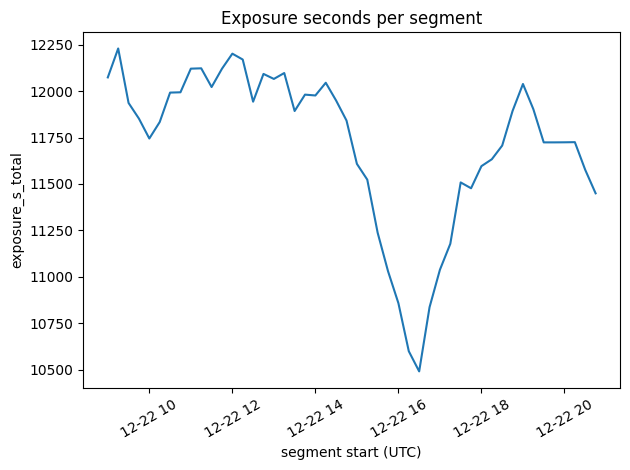

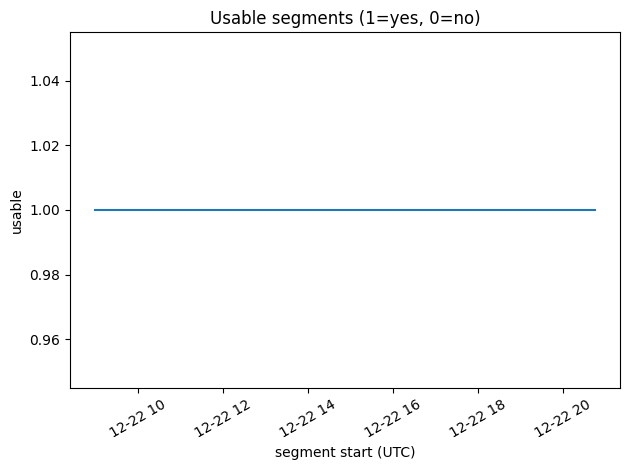

In [23]:
plt.figure()
plt.plot(df['start_dt'], df['exposure_s_total'])
plt.title('Exposure seconds per segment')
plt.xlabel('segment start (UTC)')
plt.ylabel('exposure_s_total')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df['start_dt'], df['usable'].astype(int))
plt.title('Usable segments (1=yes, 0=no)')
plt.xlabel('segment start (UTC)')
plt.ylabel('usable')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Parameter stability
A and k can be hard to interpret directly; implied λ(δ) at a few deltas is often more intuitive.

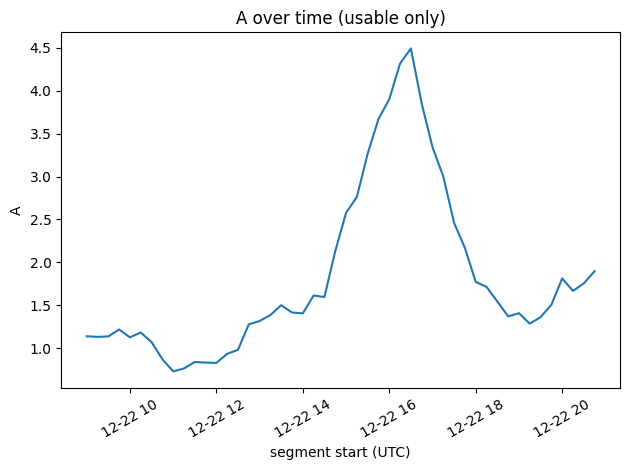

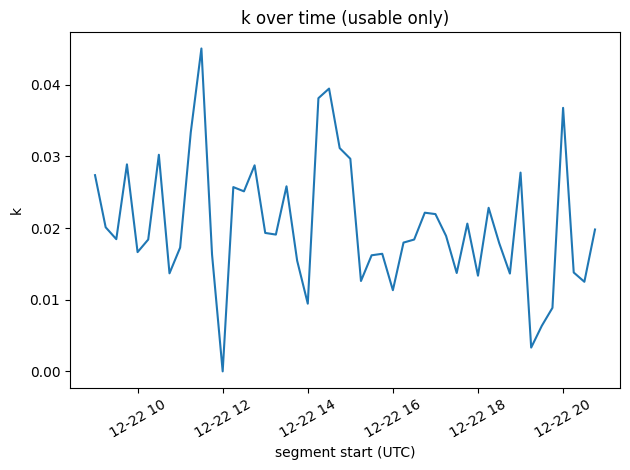

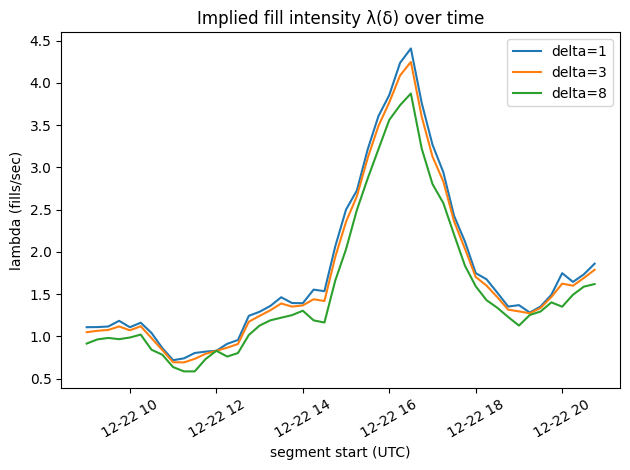

In [24]:
usable = df[df['usable'] == True].copy()

plt.figure()
plt.plot(usable['start_dt'], usable['A'])
plt.title('A over time (usable only)')
plt.xlabel('segment start (UTC)')
plt.ylabel('A')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(usable['start_dt'], usable['k'])
plt.title('k over time (usable only)')
plt.xlabel('segment start (UTC)')
plt.ylabel('k')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df['start_dt'], df['lambda_d1'], label='delta=1')
plt.plot(df['start_dt'], df['lambda_d3'], label='delta=3')
plt.plot(df['start_dt'], df['lambda_d8'], label='delta=8')
plt.title('Implied fill intensity λ(δ) over time')
plt.xlabel('segment start (UTC)')
plt.ylabel('lambda (fills/sec)')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Optional: correlate parameters with market regime (trade rate)
If you have trades for the day available locally, this provides a quick sanity check: A should loosely track trade activity / liquidity.

In [25]:
# Optional: load trades. This assumes your normal file layout and parsers.
try:
    from mm.backtest.io import find_trades_file, iter_trades_csv
    p = find_trades_file(DATA_ROOT, SYMBOL, DAY)
    rows = []
    for tr in iter_trades_csv(p):
        rows.append((int(tr.recv_ms), float(tr.price), float(tr.qty)))
    trades = pd.DataFrame(rows, columns=['recv_ms', 'price', 'qty'])
    trades['dt'] = pd.to_datetime(trades['recv_ms'], unit='ms', utc=True)
    print('Loaded trades:', len(trades), 'from', p)
except Exception as e:
    trades = None
    print('Could not load trades (optional):', repr(e))


Loaded trades: 3290291 from /Users/hoangdeveloper/PycharmProjects/MMPrototype/data/BTCUSDT/20251222/trades_ws_BTCUSDT_20251222.csv.gz


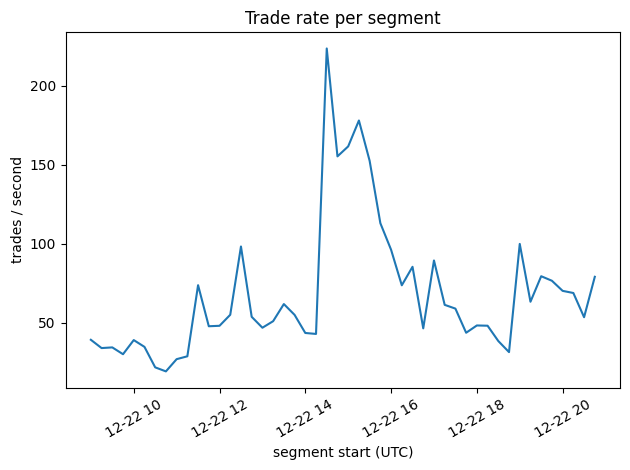

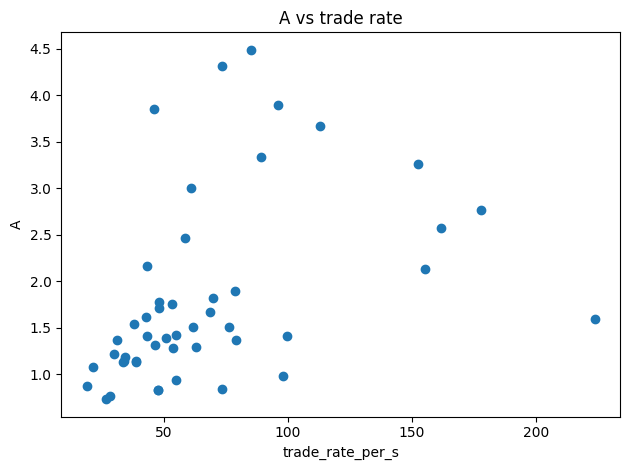

In [26]:
if trades is not None and len(trades):
    # Trade rate per segment
    seg_rates = []
    for _, r in df.iterrows():
        m = (trades['recv_ms'] >= r['start_ms']) & (trades['recv_ms'] < r['end_ms'])
        n = int(m.sum())
        dur_s = (r['end_ms'] - r['start_ms']) / 1000.0
        seg_rates.append(n / dur_s if dur_s > 0 else 0.0)
    df['trade_rate_per_s'] = seg_rates

    plt.figure()
    plt.plot(df['start_dt'], df['trade_rate_per_s'])
    plt.title('Trade rate per segment')
    plt.xlabel('segment start (UTC)')
    plt.ylabel('trades / second')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Simple correlation view
    plt.figure()
    plt.scatter(df['trade_rate_per_s'], df['A'])
    plt.title('A vs trade rate')
    plt.xlabel('trade_rate_per_s')
    plt.ylabel('A')
    plt.tight_layout()
    plt.show()
